In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
random_state = 42

In [2]:
train_df = pd.read_csv('train.csv', index_col='id')
holiday_df = pd.read_csv("holidays_events.csv")
transaction_df = pd.read_csv("transactions.csv")
store_df = pd.read_csv('stores.csv')
oil_df = pd.read_csv('oil.csv')
test_df = pd.read_csv('test.csv', index_col='id')

### Gộp dữ liệu và tạo các feature mới

In [3]:
def transform_date(date):
    # change from "MM/DD/YYYY" -> "YYYY-MM-DD"
    tmp = date.split('/')
    month, day, year = tmp[0], tmp[1], tmp[2]
    if (len(month) == 1): 
        month = '0' + month
    if (len(day) == 1): 
        day = '0' + day
    return "-".join([year, month, day])

# transform 
holiday_df['date'] = holiday_df['date'].apply(transform_date)

In [4]:
def fill_nan(series):
    n = len(series)
    arr = series.values
    for i in range(n):
        if (np.isnan(arr[i])):
            if (i - 1 < 0):
                print(i)
                v = arr[i + 1] # chưa chặt lắm
            else:
                v = arr[i - 1]
            arr[i] = v
    return arr

In [41]:
def rmsle(y_true, y_pred):
    n = y_true.shape[0]
    y_pred = np.where(y_pred > 0, y_pred, 0)
    res = np.sqrt(1/n * np.sum((np.log(1 + y_pred) - np.log(1 + y_true)) ** 2))
    return res

#### Tạo lag feature dựa vào giá dầu

In [5]:
def get_oil_lag(oil_df):
    lag_oil_df = oil_df.copy()
    lag_oil_df['month'] = pd.to_datetime(oil_df['date']).dt.month.values
    lag_oil_df['year'] = pd.to_datetime(oil_df['date']).dt.year.values
    mean_oil = lag_oil_df.groupby(['year', 'month'])['dcoilwtico'].mean().reset_index()
    mean_oil.rename(columns = {"dcoilwtico" : 'month_mean'}, inplace = True)
    fillna_vals = pd.Series([92.12,93.13, 94.14])
    mean = pd.concat([fillna_vals, mean_oil['month_mean']])
    mean_oil['last1month'] = mean.shift(1)[3:]
    mean_oil['last2month'] = mean.shift(2)[3:]
    mean_oil['last3month'] = mean.shift(3)[3:]
    lag_oil_df = lag_oil_df.merge(mean_oil, how = 'left', right_on = ['year', 'month'], left_on = ['year', 'month'])
    lag_oil_df.drop('month', inplace = True, axis = 1)
    lag_oil_df.drop('year', inplace = True, axis = 1)
    # handle missing value in oil dataframe
    lag_oil_df['dcoilwtico'] = fill_nan(lag_oil_df['dcoilwtico'])
    return lag_oil_df

In [6]:
lag_oil_df = get_oil_lag(oil_df)

0


#### Gộp và điền vào missing value

In [7]:
# main dataframe (train_df or test_df) merged with holiday_df
mh_df = train_df.merge(holiday_df, how='left', left_on = 'date', right_on = 'date')
mh_df = mh_df.fillna("None")
mhs_df = mh_df.merge(store_df, how='left', left_on = 'store_nbr', right_on = 'store_nbr')
mhso_df = mhs_df.merge(lag_oil_df, how='left', left_on = 'date', right_on = 'date')
mhso_df['dcoilwtico'] = fill_nan(mhso_df['dcoilwtico'])
mhso_df['last1month'] = fill_nan(mhso_df['last1month'])
mhso_df['last2month'] = fill_nan(mhso_df['last2month'])
mhso_df['last3month'] = fill_nan(mhso_df['last3month'])
mhso_df['month_mean'] = fill_nan(mhso_df['month_mean'])

In [30]:
test_mh_df = test_df.merge(holiday_df, how='left', left_on = 'date', right_on = 'date')
test_mh_df = test_mh_df.fillna("None")
test_mhs_df = test_mh_df.merge(store_df, how='left', left_on = 'store_nbr', right_on = 'store_nbr')
test_mhso_df = test_mhs_df.merge(lag_oil_df, how='left', left_on = 'date', right_on = 'date')
test_mhso_df['dcoilwtico'] = fill_nan(test_mhso_df['dcoilwtico'])
test_mhso_df['last1month'] = fill_nan(test_mhso_df['last1month'])
test_mhso_df['last2month'] = fill_nan(test_mhso_df['last2month'])
test_mhso_df['last3month'] = fill_nan(test_mhso_df['last3month'])
test_mhso_df['month_mean'] = fill_nan(test_mhso_df['month_mean'])
# y = get_sale_lag(test_mhso_df)
# test_lag_df = y.merge(test_mhso_df, how = 'left', left_on = ['family', 'store_nbr', 'date'], right_on = ['family', 'store_nbr', 'date'])

In [29]:
train_y = mhso_df['sales']
train_X = mhso_df.drop('sales', axis = 1)

In [14]:
train_y.to_csv('lag_train_y.csv')
train_X.to_csv('lag_train_X.csv')

In [12]:
test_mhso_df.to_csv('lag_test_X.csv')

In [36]:
def my_split_func(df, train_start_date='2013-01-01', train_end_date='2017-08-30',
               val_start_date='2017-09-01', val_end_date='2020-01-01'):
    train_start_date = pd.to_datetime(train_start_date)
    train_end_date = pd.to_datetime(train_end_date)
    val_start_date = pd.to_datetime(val_start_date)
    val_end_date = pd.to_datetime(val_end_date)
    
    train = df[(pd.to_datetime(df['date']) >= train_start_date) & (pd.to_datetime(df['date']) <= train_end_date)]
    val = df[(pd.to_datetime(df['date']) >= val_start_date) & (pd.to_datetime(df['date']) <= val_end_date)]
    return [train, val]

In [ ]:
train_df, val_df = my_split_func(mhso_df)

In [33]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from statsmodels.tsa.deterministic import DeterministicProcess, CalendarFourier
class FeatureEncoder(object):
    def __init__(self, X_df):
        weekday = pd.to_datetime(X_df['date']).dt.dayofweek.values.reshape(-1,1)
        month = pd.to_datetime(X_df['date']).dt.month.values.reshape(-1,1)
        self.family_encoder = OneHotEncoder().fit(X_df[['family']])
        self.store_type_encoder = OneHotEncoder().fit(X_df[['type_y']])
        self.week_encoder = OneHotEncoder().fit(weekday)
        self.month_encoder = OneHotEncoder().fit(month)
        self.holiday_type_encoder = OneHotEncoder().fit(X_df[['type_x']])
        self.locale_name_encoder = OneHotEncoder().fit(X_df[['locale_name']])
        self.cluster_encoder = OneHotEncoder().fit(X_df[['cluster']])
        self.city_encoder = OneHotEncoder().fit(X_df[['city']])
        self.date_idx = pd.to_datetime(X_df['date'])
    
    def date2feature(self, date_col):
        weekday = pd.to_datetime(date_col).dt.dayofweek.values.reshape(-1,1)
        month = pd.to_datetime(date_col).dt.month.values.reshape(-1,1)
        year = pd.to_datetime(date_col).dt.year.values.reshape(-1,1)
        weekday_features = self.week_encoder.transform(weekday).todense()
        month_features = self.month_encoder.transform(month).todense()
        return np.hstack([year, month_features, weekday_features])
    
    def seasonality_features(self):
        # DeterministicProcess
        fourierA = CalendarFourier(freq='A', order=5)
        fourierM = CalendarFourier(freq='M', order=2)
        fourierW = CalendarFourier(freq='W', order=4)

        dp = DeterministicProcess(index=self.date_idx,
                              order=1,
                              seasonal=False,
                              constant=False,
                              additional_terms=[fourierA, fourierM, fourierW],
                              drop=True)
        dp_df = dp.in_sample()
        return dp_df
    
    def get_sale_lag(self, mhso_df):
        x = pd.DataFrame(mhso_df.groupby(['family', 'store_nbr', 'date'])['sales'].mean()).reset_index()
        x = x.set_index(['family', 'store_nbr'])
        indices = x.index.unique()

        for idx in indices:
            sales = x.loc[idx, 'sales']
            x.loc[idx, 'sales1'] = sales.shift(1)
            x.loc[idx, 'sales2'] = sales.shift(2)
            x.loc[idx, 'sales3'] = sales.shift(3)
            x.loc[idx, 'sales4'] = sales.shift(4)
            x.loc[idx, 'sales5'] = sales.shift(5)
        y = x.dropna()
        return y
    
    def get_product_features(self, mhso_df):
        tags = {
         'AUTOMOTIVE': [4, 7, 30, 10, 'family'],
         'BABY CARE':  [-8, 2, 25, 5, 'family'],
         'BEAUTY': [-8, 7, 25, 5, 'other'],
         'BEVERAGES': [0, 0, 40, 40, 'food'],
         'BOOKS': [0, 0, 55, 15, 'other'],
         'BREAD/BAKERY': [-3, 0, 30, 30, 'food'],
         'CELEBRATION': [-5, 5, 50, 20, 'family'],
         'CLEANING': [-8, 3, 40, 20, 'food'],
         'DAIRY': [-4, 0, 40, 40, 'food'],
         'DELI': [3, 6, 40, 20, 'food'],
         'EGGS': [-4, -5, 40, 20, 'food'],
         'FROZEN FOODS': [-4, -3, 40, 20, 'food'],
         'GROCERY I': [-4, 3, 40, 20, 'food'],
         'GROCERY II': [-4, 3, 40, 20, 'food'],
         'HARDWARE': [10, 10, 30, 20, 'other'],
         'HOME AND KITCHEN I': [-10, 4, 40, 20, 'family'],
         'HOME AND KITCHEN II': [-10, 4, 40, 20, 'family'],
         'HOME APPLIANCES': [0, 4, 40, 20, 'family'],
         'HOME CARE': [-10, 4, 40, 20, 'family'],
         'LADIESWEAR': [-10, 4, 40, 20, 'other'],
         'LAWN AND GARDEN': [-10, 4, 40, 20, 'family'],
         'LINGERIE': [-10, 4, 40, 2, 'other'],
         'LIQUOR,WINE,BEER': [4, 8, 40, 20, 'food'],
         'MAGAZINES': [-6, -7, 50, 20, 'other'],
         'MEATS': [-4, 5, 40, 20, 'food'],
         'PERSONAL CARE': [-5, 5, 40, 20, 'family'],
         'PET SUPPLIES': [-5, 0, 40, 20, 'family'],
         'PLAYERS AND ELECTRONICS': [5, 5, 25, 10, 'other'],
         'POULTRY': [-7, -4, 40, 20, 'food'],
         'PREPARED FOODS': [0, 6, 30, 10, 'food'],
         'PRODUCE': [0, 0, 40, 40, 'other'],
         'SCHOOL AND OFFICE SUPPLIES': [3, 3, 25, 15, 'family'],
         'SEAFOOD': [-5, 8, 40, 20, 'food']
        }

        sex_dict = {}
        luxury_dict = {}
        age_mean_dict = {}
        age_var_dict = {}
        type_dict = {}
        for i in tags.keys():
            sex_dict[i] = tags[i][0]
            luxury_dict[i] = tags[i][1]
            age_mean_dict[i] = tags[i][2]
            age_var_dict[i] = tags[i][3]
            type_dict[i] = tags[i][4]
            
        def foo(i):
            return pd.Series({   
                "sex": sex_dict[i],
                "luxury": luxury_dict[i],
                "age_mean": age_mean_dict[i],
                "age_var": age_var_dict[i],
                "type": type_dict[i]
            })

        product_info_df = mhso_df['family'].apply(foo)
        return product_info_df
    
    def preprocess(self, mhso_df):
        date_features = self.date2feature(mhso_df['date'])
        family_features = self.family_encoder.transform(mhso_df[['family']]).todense()
        onpromotion = mhso_df['onpromotion'].values.reshape(-1, 1)
        holiday_type_features = self.holiday_type_encoder.transform(mhso_df[['type_x']]).todense()
        locale_name_features = self.locale_name_encoder.transform(mhso_df[['locale_name']]).todense()
        store_type_features = self.store_type_encoder.transform(mhso_df[['type_y']]).todense()
        cluster_features = self.cluster_encoder.transform(mhso_df[['cluster']]).todense()
        city_features = self.city_encoder.transform(mhso_df[['city']]).todense()
        oil_lags = mhso_df.loc[:, ['month_mean', 'last1month', 'last2month', 'last3month']].values # oil lag
        sale_lags = self.get_sale_lag(mhso_df)
        seasonality_features = self.seasonality_features()
        product_features = self.get_product_features(mhso_df)
        X = np.hstack([date_features, 
                       family_features, 
                       onpromotion, 
                       holiday_type_features, 
                       locale_name_features, 
                       store_type_features, 
                       cluster_features, 
                       city_features, 
                       oil_lags,
                       sale_lags, 
                       product_features])
        return X
encoder = FeatureEncoder(train_df)
X_train = encoder.preprocess(train_df)
y_train = train_df['sales']
print(X.shape, y.shape)

(3054348, 134) (3054348,)


In [ ]:
# todo: viết sale lag cho test

### Huấn luyện mô hình

In [40]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators = 10)
model.fit(X, y)

C:\Users\thamnt36\Anaconda3\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


RandomForestRegressor(n_estimators=10)

### Evaluate model

In [30]:
test_X = encoder.preprocess(test_mhso_df)
test_X.shape

(28512, 134)

### Predict test value

In [34]:
y_pred = model.predict(test_X)
y_pred = np.where(y_pred > 0, y_pred, 0)
submit = pd.DataFrame(np.hstack([test_df.index.values.reshape(-1, 1), y_pred.reshape(-1, 1)]), columns = ['id', 'sales'])
submit.id = submit.id.astype(np.int32)
submit.to_csv('submit.csv', index=False)

C:\Users\thamnt36\Anaconda3\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


In [ ]:
# TODO:
# tương quan giữa oil lag feature và sales
# thêm sales lag feature
# feature selection

In [40]:
x = train_X.loc[:, ['month_mean', 'last1month', 'last2month', 'last3month']]
x = pd.concat([x, train_y], axis = 1)
x.head(3)

,month_mean,last1month,last2month,last3month,sales
0,94.756667,94.14,93.13,92.12,0.0
1,94.756667,94.14,93.13,92.12,0.0
2,94.756667,94.14,93.13,92.12,0.0


<AxesSubplot:>

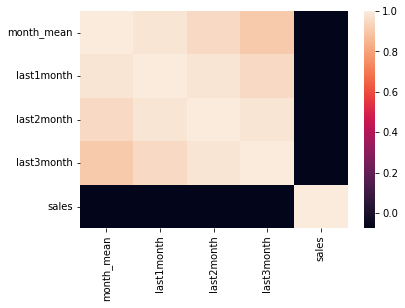

In [41]:
import seaborn as sns
sns.heatmap(x.corr(), )

### Ideas

In [24]:
store_groups = mhso_df.groupby(['store_nbr', 'family'])['sales'].sum()
pairs = store_groups.index[store_groups == 0]
not_sell = {}
for store, item in pairs:
    if store not in not_sell.keys():
        not_sell[store] = [item]
    else:
        not_sell[store].append(item)    

{1: ['BABY CARE'],
 9: ['BOOKS'],
 10: ['BOOKS'],
 11: ['BOOKS'],
 12: ['BOOKS'],
 13: ['BABY CARE', 'BOOKS'],
 14: ['BOOKS', 'LAWN AND GARDEN'],
 15: ['BOOKS'],
 16: ['BOOKS', 'LADIESWEAR'],
 17: ['BOOKS'],
 18: ['BOOKS'],
 19: ['BOOKS'],
 20: ['BOOKS'],
 21: ['BOOKS'],
 22: ['BOOKS'],
 23: ['BABY CARE'],
 25: ['LADIESWEAR'],
 28: ['BOOKS', 'LADIESWEAR'],
 29: ['BOOKS', 'LADIESWEAR'],
 30: ['BOOKS', 'LAWN AND GARDEN'],
 31: ['BOOKS'],
 32: ['BOOKS', 'LADIESWEAR'],
 33: ['BOOKS', 'LADIESWEAR'],
 34: ['BOOKS'],
 35: ['BOOKS', 'LADIESWEAR'],
 36: ['BOOKS'],
 39: ['BOOKS'],
 40: ['BOOKS', 'LADIESWEAR'],
 43: ['BOOKS', 'LADIESWEAR'],
 44: ['BABY CARE'],
 45: ['BABY CARE'],
 46: ['BABY CARE'],
 47: ['BABY CARE'],
 48: ['BABY CARE'],
 49: ['BABY CARE'],
 50: ['BABY CARE'],
 51: ['BABY CARE'],
 52: ['BABY CARE', 'BOOKS'],
 54: ['BOOKS', 'LADIESWEAR', 'LAWN AND GARDEN']}

In [25]:
def isSell(store, item):
    not_sell = {1: ['BABY CARE'], 9: ['BOOKS'], 10: ['BOOKS'], 11: ['BOOKS'],
     12: ['BOOKS'], 13: ['BABY CARE', 'BOOKS'], 14: ['BOOKS', 'LAWN AND GARDEN'],
     15: ['BOOKS'], 16: ['BOOKS', 'LADIESWEAR'], 17: ['BOOKS'], 18: ['BOOKS'],
     19: ['BOOKS'], 20: ['BOOKS'], 21: ['BOOKS'], 22: ['BOOKS'], 23: ['BABY CARE'],
     25: ['LADIESWEAR'], 28: ['BOOKS', 'LADIESWEAR'], 29: ['BOOKS', 'LADIESWEAR'],
     30: ['BOOKS', 'LAWN AND GARDEN'], 31: ['BOOKS'], 32: ['BOOKS', 'LADIESWEAR'],
     33: ['BOOKS', 'LADIESWEAR'], 34: ['BOOKS'], 35: ['BOOKS', 'LADIESWEAR'],
     36: ['BOOKS'], 39: ['BOOKS'], 40: ['BOOKS', 'LADIESWEAR'], 43: ['BOOKS', 'LADIESWEAR'],
     44: ['BABY CARE'], 45: ['BABY CARE'], 46: ['BABY CARE'], 47: ['BABY CARE'],
     48: ['BABY CARE'], 49: ['BABY CARE'], 50: ['BABY CARE'], 51: ['BABY CARE'],
     52: ['BABY CARE', 'BOOKS'], 54: ['BOOKS', 'LADIESWEAR', 'LAWN AND GARDEN']}
    if store in not_sell.keys():
        if item in not_sell[store]:
            return False
    return True

In [26]:
isSell(16, 'BOOKS')

False